# COx vs MAP

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import zoll
from utils import nirs
from utils import misc
from utils.autoscale import autoscale

In [2]:
# parameters
case_id = 1
step_id = 7

In [3]:
case_str = str(case_id).zfill(5)
output_file = f'output/{case_str}_{step_id}.csv'
input_file = 'output/' + case_str + '_6.csv'

In [4]:
# load data
df = pd.read_csv(input_file,
                 sep = ',',
                 na_values = ['-'],
                 parse_dates = ['Time'])
misc.NormalizeTime(df)
df.set_index('Time', inplace=True)
mark_timestamp = df.loc[df['Mark'] == 1].index[0]

In [5]:
# dropout
df['rSO2'] = np.where(df['Bad_rSO2_manual'] == 1, np.nan, df['rSO2'])
df['MAP'] = np.where(df['Bad_MAP_auto'] == 1, np.nan, df['MAP'])
df['MAP'] = np.where(df['Bad_MAP_manual'] == 1, np.nan, df['MAP'])

In [6]:
# smooth rSO2 to match MAP
df['rSO2'] = df['rSO2'].rolling(10).mean()

In [7]:
# resampling as per Ono, Joshi, Brady, Easley et al. 2012
resampled_df = pd.DataFrame()
resampled_df['MAP'] = df['MAP'].resample('10s').mean()
resampled_df['rSO2'] = df['rSO2'].resample('10s').mean()

In [8]:
def custom_round(x, base=5):
    if (np.isnan(x)): return np.nan
    return base * round(float(x)/base)

In [9]:
df['MAP_rounded'] = df['MAP'].apply(lambda x: custom_round(x))

In [10]:
binned_df = df.groupby(['MAP_rounded']).mean()
binned_df

,MAP,Bad_MAP_auto,Bad_MAP_manual,rSO2,Mark,Bad_rSO2_auto,Bad_rSO2_manual,COx
MAP_rounded,,,,,,,,
65.0,66.964743,0.0,0.0,68.051393,0.00000,0.000000,0.0,-0.325448
70.0,69.885161,0.0,0.0,77.628613,0.00000,0.000000,0.0,-0.585346
75.0,75.258400,0.0,0.0,82.820750,0.00000,0.000000,0.0,-0.443810
80.0,80.532730,0.0,0.0,80.000957,0.00000,0.000000,0.0,0.080320
85.0,85.466698,0.0,0.0,77.619674,0.00000,0.000000,0.0,0.185878
90.0,90.771539,0.0,0.0,82.856200,0.00000,0.000000,0.0,-0.224835
95.0,95.847333,0.0,0.0,85.865863,0.00000,0.000000,0.0,-0.143102
100.0,100.206358,0.0,0.0,88.044958,0.00000,0.000912,0.0,0.096134
105.0,104.944401,0.0,0.0,85.402616,0.00158,0.000000,0.0,-0.066770


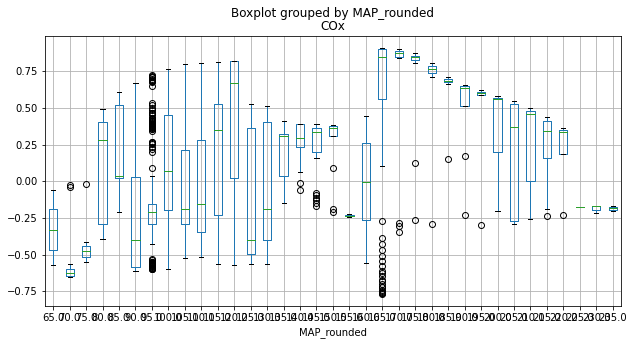

In [11]:
df.boxplot(column = 'COx', by = 'MAP_rounded', figsize = (10, 5));
plt.savefig(f'reports/images/{step_id}_{case_str}_01.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

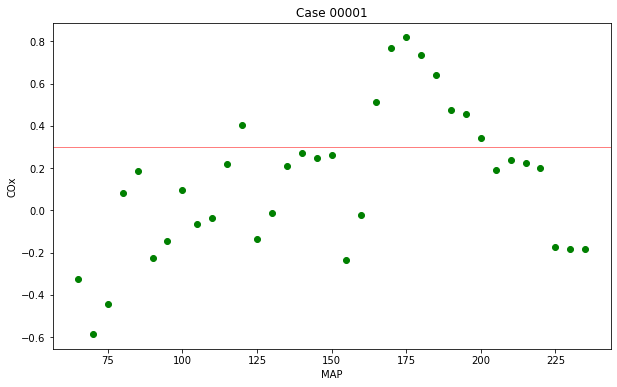

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(binned_df.index, binned_df['COx'], c='g')
ax.set_title(f'Case {case_str}')
ax.set_xlabel('MAP')
ax.set_ylabel('COx')
ax.axhline(0.3, linewidth=0.5, color="red")
plt.savefig(f'reports/images/{step_id}_{case_str}_02.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [13]:
df['MAP_interpolated'] = df['MAP'].interpolate(limit_area='inside')
df['COx_interpolated'] = df['rSO2'].rolling(300).corr(df['MAP_interpolated'])

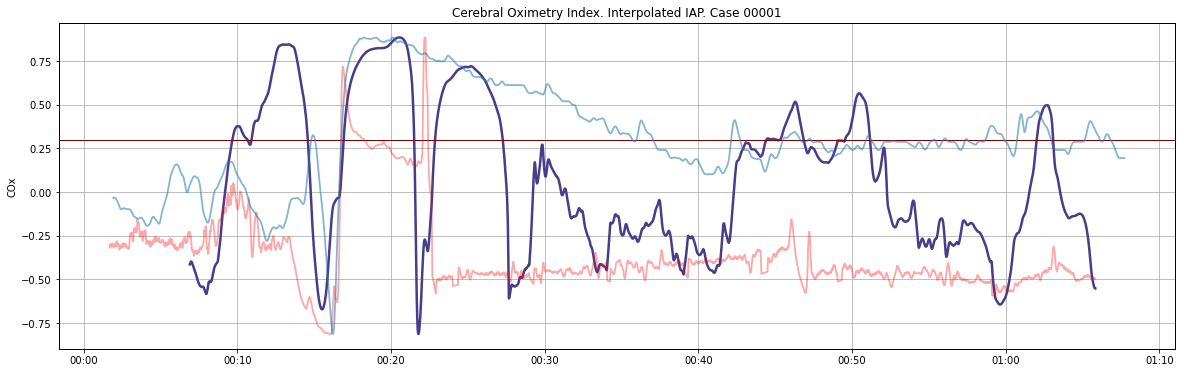

In [14]:
fig, ax1 = plt.subplots(figsize=(20,6))
ax1.set_ylabel('COx')
ax1.plot(df.index, df['COx_interpolated'], linewidth=2.5, color='darkslateblue')
ax2 = ax1.twinx()
ax2.plot(df.index, df['MAP_interpolated'], linewidth=1.8, alpha=0.35, color='red')
ax3 = ax1.twinx()
ax3.plot(df.index, df['rSO2'], linewidth=1.8, alpha=0.55)
ax2.set_yticks([])
ax3.set_yticks([])
ax1.grid()
ax1.axhline(0.3, linewidth=1, color="maroon")
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
plt.title(f'Cerebral Oximetry Index. Interpolated IAP. Case {case_str}')
#plt.savefig(f'reports/images/{step_id}_{case_str}_02.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [15]:
# save output
#df[['MAP', 'Bad_MAP_auto', 'Bad_MAP_manual', 'rSO2', 'Mark', 'Bad_rSO2_auto', 'Bad_rSO2_manual', 'COx', 'Elapsed']].to_csv(output_file, na_rep='-', date_format='%H:%M:%S')